# Butts's Mutual Information analysis for a set of spike trains

This module computes Mutual Information (MI) between interspike/interburst intervals (ISI) of _different_ neurons in a set of neurons and differences in neuron features.
In Butts's [original paper](https://doi.org/10.1523/JNEUROSCI.21-03-00961.2001), a feature is a position of retinal ganglion cell of developing retina during the period of retinal spontaneous activity (retinal waves).
Because the correlation between activity decays with distance, ISIs convey a finite amount of information about the distance between spike sources (neurons) in the retina.
This information is extracted by subcortical regions, such as the visual thalamus and superior calculus, to refine connections from the retina and create exact retinotopic maps in both nuclei.
![](MI_dFDT.svg)

Butts also suggested an elegant method to assess the timescale of informative correlation by jittering recorded spikes and computing MI. The magnitude of the jitter, when MI starts to decay, defines the lower bound of the timescale of informative correlations.

This analysis can be extended to any feature, not necessarily differences in positions, and therefore, can be useful for assessing information conveyed in spike differences from a set of neurons.


---

This module provides two classes `ButtsMI` and '`ButtsMIkde`

The first one, `ButtsMI`, computes MI and jitter-based correlational timescale using histogram method. The class computes MI based on conditional distributions (Eq. 6 in the paper):
$$
I(\Delta f,\Delta t) = \sum_{\Delta f} p(\Delta f) \sum_{\Delta t} p(\Delta t| \Delta f) ~ \log_2 \left[ \frac{p(\Delta t| \Delta f)}{p(\Delta t)}\right]
$$
where, $\Delta f$ - difference between features, $\Delta t$ -interspike/interburst intervals. **Nonte.** To applay correction (Eq. 2 in the paper), set `CorrectMI=True` and to stop computation if MI is negative set `BlockCorrect=True`.


The second one is `ButtsMIkde` and it does the same computations based on kernel density estimators. The class computes MI as 
$$
I[\Delta f, \Delta T]= \iint_{V=(\Delta f,\Delta t)} P_{(\Delta f,\Delta t)}(x,y) \log{\frac{P_{(\Delta f,\Delta t)}(x,y)}{P_{\Delta f}(x)P_{\Delta t}(y)}} dx dy
$$
where $P_{(\Delta f,\Delta t)}(\Delta f,\Delta t)$ is an 2D estimator of probability dencity for join distribution of $(\Delta f,\Delta t)$, and $P_{\Delta f}(\Delta f)$ and $P_{\Delta t}(\Delta t)$ are marginal 1D propability density estimators.






## An example: population of modulated Poisson processes.

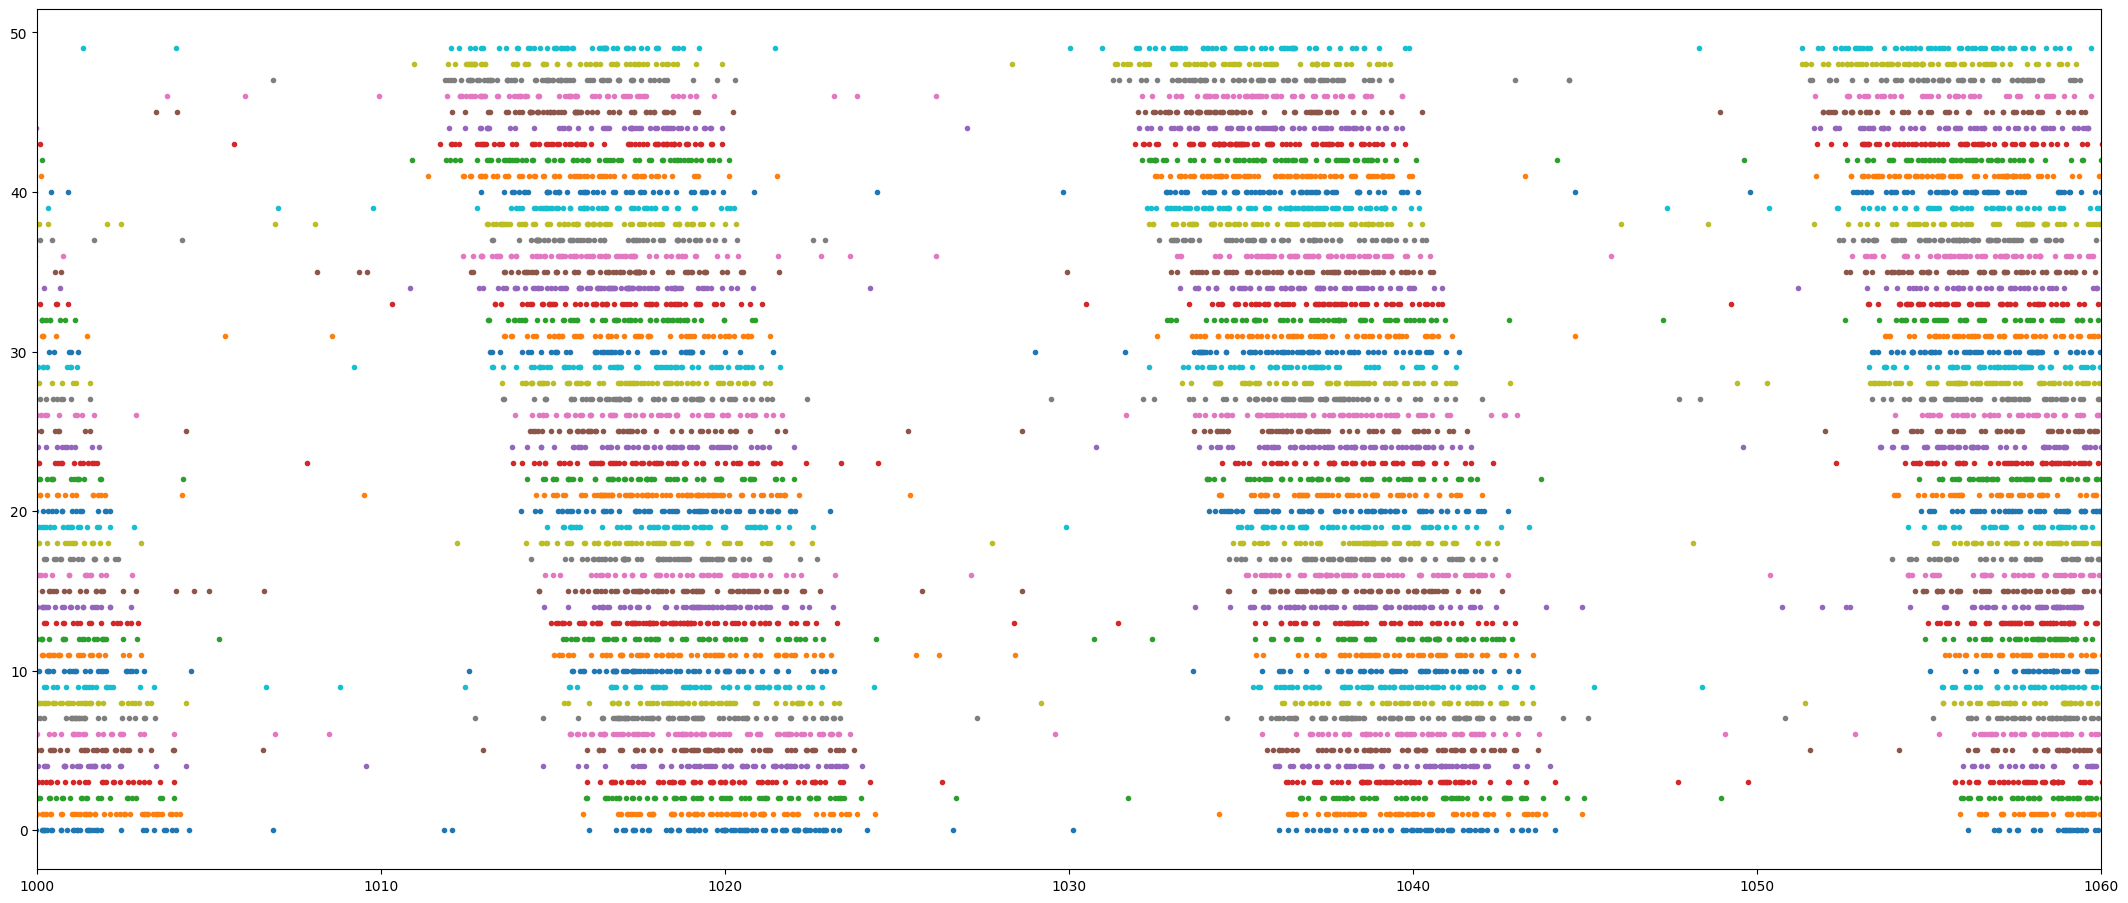

In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
getnextspike = lambda t,r: t+random.exponential(scale=1./r)
Nneurons = 50
baserate =  0.1  # spikes per second
peakrate = 10.   # spikes per second
thr_rate =  3.   # minimal rate for burst onset
modper   = 20.   # 20 second period 
duration = 40*60 # in seconds
nrnphase = [ nid*pi/2./Nneurons for nid in range(Nneurons)]
tscan    = arange(0,modper,1)+1
spikes   = []
for nid,dphy in enumerate(nrnphase):
    t = 0
    spikes.append([])
    while True:
        r = peakrate*cos(2*pi*t/modper+dphy)
        if r < thr_rate: r=baserate
        t1 = getnextspike(t,r)
        r0 = peakrate*cos(2*pi*(t+tscan)/modper+dphy)
        t0 = tscan[where(r0 >= thr_rate)]
        
        t = min([t1,t+t0[0]])
        if t >= duration: break
        spikes[-1].append(t)
    spikes[-1] = array(spikes[-1])
figure(figsize=(24,10))
for nid,s in enumerate(spikes):
    plot(s,nid*ones(s.shape[0]),'.')
xlim(1000, 1060)
show()

### Computing MI and Informative timescale of _Bursts_

By default `ButtsMI` class extracts burst onset time (BOST) first, and then computes MI.

**Note** If any histogram containes zero in any bin, the code will generate `RuntimeWarning`, which should be ignored. `nan` are taken into account by `nansum` function.


/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: invalid value encountered in divide
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: divide by zero encountered in log2
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: invalid value encountered in multiply
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )


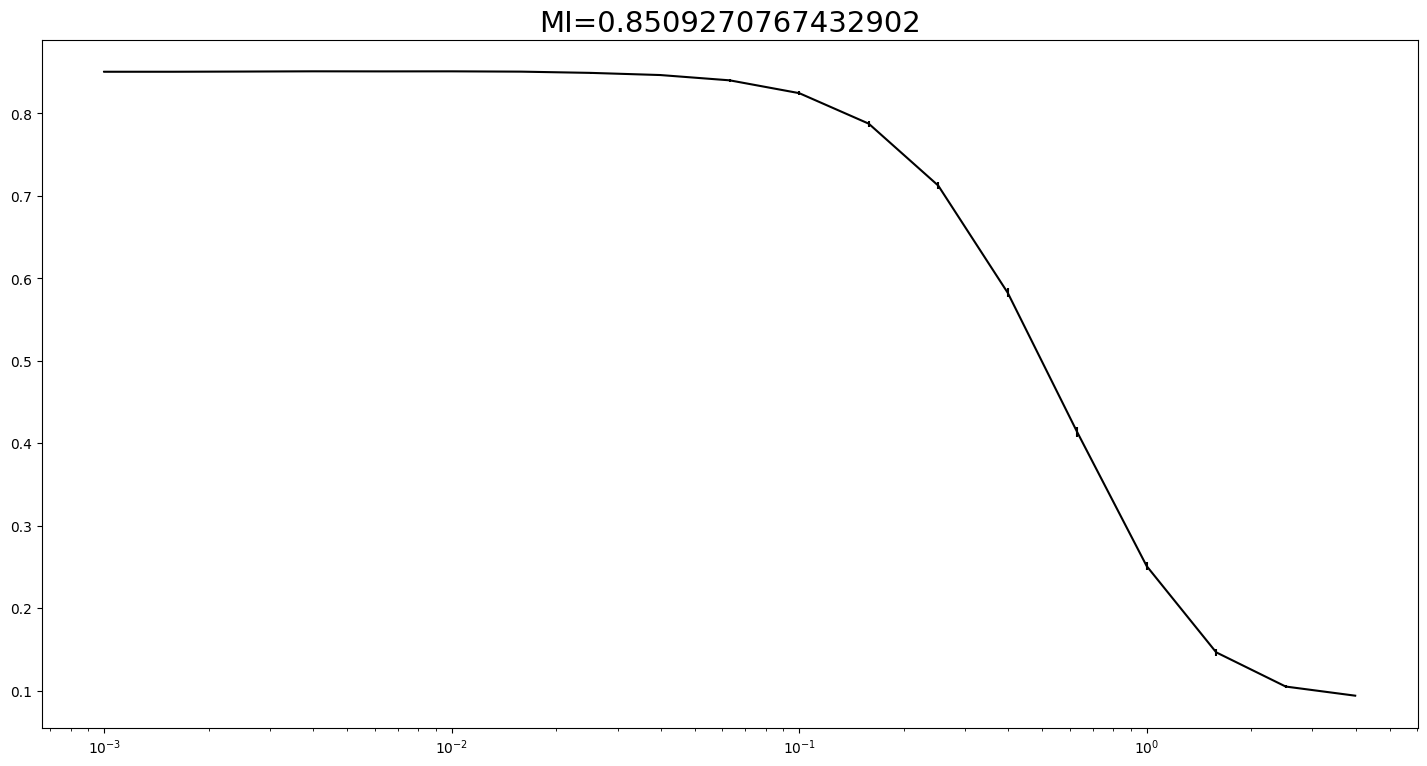

In [2]:
from ButtsMI import ButtsMI
bmi = ButtsMI(jTparallel=True)
ret = bmi(nrnphase,spikes)
if ret is None:
    MI = None
else:
    MI,jitrange,meanjMI,stdjMI = ret
    
    

if not MI is None:
    figure(figsize=(16,8))
    title(f'MI={MI}',fontsize=21)
    if stdjMI is None:
        plot(jitrange,meanjMI,'ko')
    else:
        errorbar(jitrange,meanjMI,yerr=stdjMI,fmt='k-')
    
    xscale('log')
    show()

### Computing MI and Informative timescale of _Spikes_

If the argument `reduceBOS` of the class or class atribute is set to False, the `ButtsMI` will compute MI without BOST filtering.

/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: invalid value encountered in divide
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: divide by zero encountered in log2
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: invalid value encountered in multiply
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: divide by zero encountered in log2
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi.py:332: RuntimeWarning: invalid value encountered in multiply
  MI += pdf * nansum( p_dT_dF[didx] * log2(p_dT_dF[didx]/p_dT) )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butt

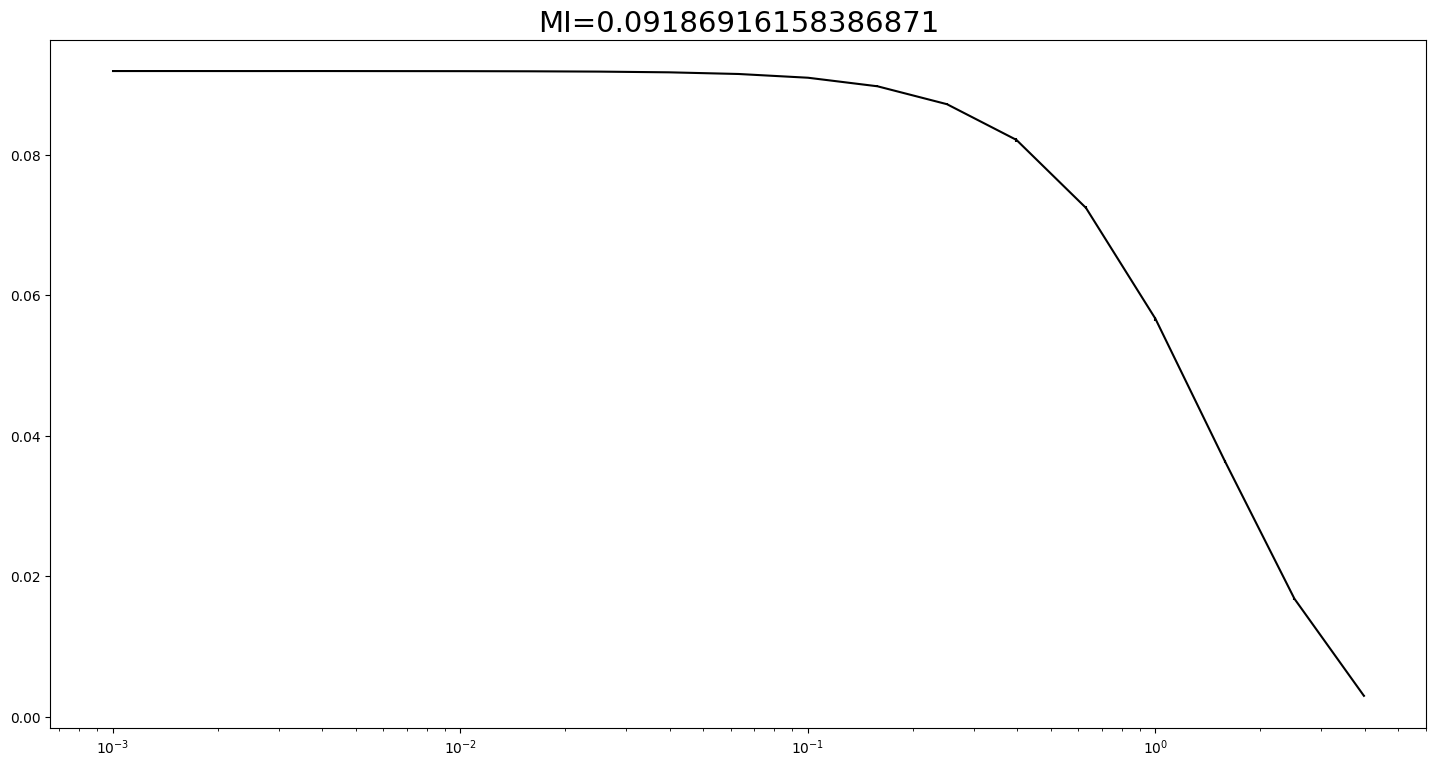

In [3]:
bmi.reduceBOS = False
ret = bmi(nrnphase,spikes)
if ret is None:
    MI = None
else:
    MI,jitrange,meanjMI,stdjMI = ret
    
    

if not MI is None:
    figure(figsize=(16,8))
    title(f'MI={MI}',fontsize=21)
    if stdjMI is None:
        plot(jitrange,meanjMI,'o')
    else:
        errorbar(jitrange,meanjMI,yerr=stdjMI,fmt='k-')
    
    xscale('log')
    show()

## Computing MI and informative timescale of _Bursts_ using __Kernel Density Estimators__

This examples shows how to use `ButtsMIkde` class to compute mutual information.

2024-02-28 20:36:28,345:225   INFO    :Burst Filtered
2024-02-28 20:36:28,564:159   INFO    :Got dF,dT list of size = (176539, 2)
2024-02-28 20:36:28,565:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-28 20:36:28,565:161   INFO    :dT_min=0.00, dT_max=11.00
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi_kde.py:120: RuntimeWarning: invalid value encountered in double_scalars
  d = pdFdT*log2( pdFdT/pdF/pdT )
/media/rth/rth-core/projects/ButtsMI/butts_mi/ButtsMI/butts_mi_kde.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  d = pdFdT*log2( pdFdT/pdF/pdT )
2024-02-28 20:43:22,325:229   INFO    :MI computed 0.21793820088084556, 1.4365421866415379e-08
2024-02-28 20:43:22,636:159   INFO    :Got dF,dT list of size = (176539, 2)
2024-02-28 20:43:22,636:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-28 20:43:22,636:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-28 20:52:31,677:214   INFO    :Computed 1th jitter amplitude of the 75: MI=0.21794994152383418

2024-02-28 23:26:26,779:159   INFO    :Got dF,dT list of size = (176547, 2)
2024-02-28 23:26:26,779:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-28 23:26:26,780:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-28 23:32:36,702:214   INFO    :Computed 22th jitter amplitude of the 75: MI=0.2164239704649477, ERROR=1.476768164456e-08
2024-02-28 23:32:37,014:159   INFO    :Got dF,dT list of size = (176537, 2)
2024-02-28 23:32:37,014:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-28 23:32:37,015:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-28 23:38:36,192:214   INFO    :Computed 23th jitter amplitude of the 75: MI=0.2140495160606692, ERROR=1.4750873600907945e-08
2024-02-28 23:38:36,502:159   INFO    :Got dF,dT list of size = (176562, 2)
2024-02-28 23:38:36,502:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-28 23:38:36,503:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-28 23:49:41,154:214   INFO    :Computed 24th jitter amplitude of the 75: MI=0.20610788254256251, ERROR=1.4873909401

2024-02-29 02:20:26,180:211   WARNING :Mutual Information is bellow zero -0.010907180437927195
2024-02-29 02:20:26,181:214   INFO    :Computed 44th jitter amplitude of the 75: MI=-0.010907180437927195, ERROR=1.4892333382511763e-08
2024-02-29 02:20:26,481:159   INFO    :Got dF,dT list of size = (170869, 2)
2024-02-29 02:20:26,481:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-29 02:20:26,482:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-29 02:28:26,889:207   WARNING :Integration error is higher that mutual information value: 1.4811473908260269e-08 > -0.010807978630764485
2024-02-29 02:28:26,890:211   WARNING :Mutual Information is bellow zero -0.010807978630764485
2024-02-29 02:28:26,890:214   INFO    :Computed 45th jitter amplitude of the 75: MI=-0.010807978630764485, ERROR=1.4811473908260269e-08
2024-02-29 02:28:27,201:159   INFO    :Got dF,dT list of size = (176546, 2)
2024-02-29 02:28:27,202:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-29 02:28:27,203:161   INFO    :dT_min=0.

2024-02-29 05:22:17,881:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-29 05:32:57,315:214   INFO    :Computed 66th jitter amplitude of the 75: MI=0.21772478388195982, ERROR=1.4810208192594975e-08
2024-02-29 05:32:57,624:159   INFO    :Got dF,dT list of size = (176543, 2)
2024-02-29 05:32:57,625:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-29 05:32:57,625:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-29 05:40:39,828:214   INFO    :Computed 67th jitter amplitude of the 75: MI=0.21688060624478647, ERROR=1.4702128438216566e-08
2024-02-29 05:40:40,140:159   INFO    :Got dF,dT list of size = (176516, 2)
2024-02-29 05:40:40,141:160   INFO    :dF_min=0.02, dF_max=1.69
2024-02-29 05:40:40,141:161   INFO    :dT_min=0.00, dT_max=11.00
2024-02-29 05:47:45,376:214   INFO    :Computed 68th jitter amplitude of the 75: MI=0.2133149811234374, ERROR=1.4694284749485215e-08
2024-02-29 05:47:45,685:159   INFO    :Got dF,dT list of size = (176527, 2)
2024-02-29 05:47:45,686:160   INFO    :dF_min=0.

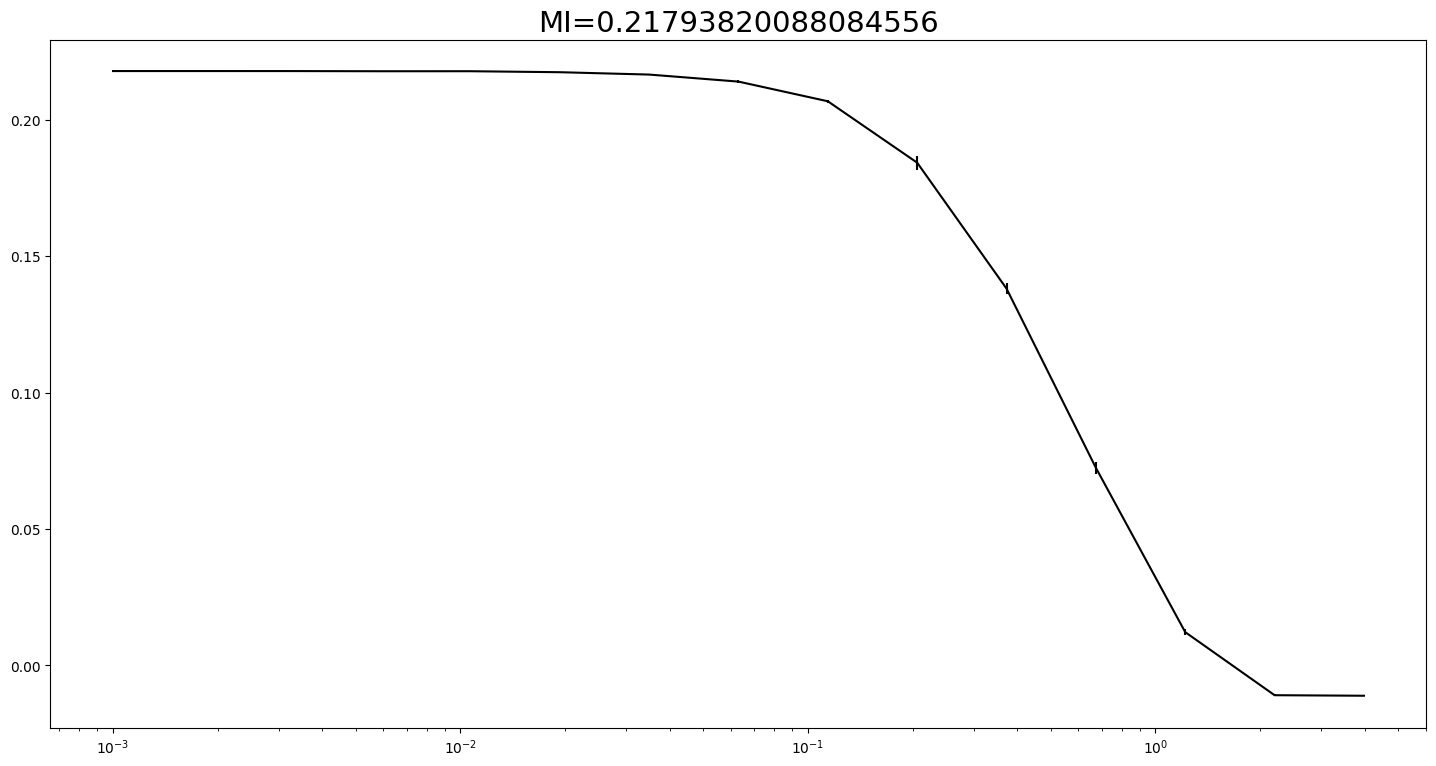

In [4]:
import logging
logging.basicConfig(
    format='%(asctime)s:%(lineno)-6d%(levelname)-8s:%(message)s',\
    level=logging.INFO)

from ButtsMI import ButtsMIkde
bmikde = ButtsMIkde(jitrep=5,jitNbin=15)
ret    = bmikde(nrnphase,spikes)
if ret is None:
    MI = None
else:
    MI,jitrange,meanjMI,stdjMI = ret

if not MI is None:
    figure(figsize=(16,8))
    title(f'MI={MI}',fontsize=21)
    if stdjMI is None:
        plot(jitrange,meanjMI,'ko')
    else:
        errorbar(jitrange,meanjMI,yerr=stdjMI,fmt='k-')
    
    xscale('log')
    show()